<a href="https://colab.research.google.com/github/alfandisusilo/leaf_vision/blob/main/neural_network/convolutional_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
# Download dataset
!wget --no-check-certificate \
    https://raw.githubusercontent.com/alfandisusilo/leaf_vision/main/jambu_biji_and_seledri_filtered.zip \
    -O /tmp/jambu_biji_and_seledri_filtered.zip

--2021-11-14 08:53:55--  https://raw.githubusercontent.com/alfandisusilo/leaf_vision/main/jambu_biji_and_seledri_filtered.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13234057 (13M) [application/zip]
Saving to: ‘/tmp/jambu_biji_and_seledri_filtered.zip’

/tmp/jambu_biji_and 100%[===================>]  12.62M  --.-KB/s    in 0.1s    

2021-11-14 08:53:56 (130 MB/s) - ‘/tmp/jambu_biji_and_seledri_filtered.zip’ saved [13234057/13234057]



In [42]:
# Ekstrak dataset

import os
import zipfile

local_zip = '/tmp/jambu_biji_and_seledri_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [43]:
# Definisikan path untuk data train dan data validation

base_dir = '/tmp/jambu_biji_and_seledri_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [44]:
import cv2
import numpy as np

# Gather data train
train_data = []
train_label = []
for r, d, f in os.walk(train_dir):
    for file in f:
        if ".jpg" in file:
            imagePath = os.path.join(r, file)
            image = cv2.imread(imagePath)
            image = cv2.resize(image, (150,150))
            train_data.append(image)
            label = imagePath.split(os.path.sep)[-2]
            train_label.append(label)

train_data = np.array(train_data)
train_label = np.array(train_label)

In [45]:
# Gather data validation
val_data = []
val_label = []
for r, d, f in os.walk(validation_dir):
    for file in f:
        if ".jpg" in file:
            imagePath = os.path.join(r, file)
            image = cv2.imread(imagePath)
            image = cv2.resize(image, (150,150))
            val_data.append(image)
            label = imagePath.split(os.path.sep)[-2]
            val_label.append(label)

val_data = np.array(val_data)
val_label = np.array(val_label)

<h3>Data Preprocessing</h3>

In [46]:
# Tampilkan shape dari data train dan data validation
print("Train Data = ", train_data.shape)
print("Train Label = ", train_label.shape)
print("Validation Data = ", val_data.shape)
print("Validation Label = ", val_label.shape)

Train Data =  (80, 150, 150, 3)
Train Label =  (80,)
Validation Data =  (20, 150, 150, 3)
Validation Label =  (20,)


In [47]:
# Normalisasi dataset
print("Data sebelum di-normalisasi ", train_data[0][0][0])

x_train = train_data.astype('float32') / 255.0
x_val = val_data.astype('float32') / 255.0
print("Data setelah di-normalisasi ", x_train[0][0][0])

Data sebelum di-normalisasi  [255 255 255]
Data setelah di-normalisasi  [1. 1. 1.]


In [68]:
# Transformasi label encoder
from sklearn.preprocessing import LabelEncoder

print("Label sebelum di-encoder ", train_label[995:1005])

lb = LabelEncoder()
y_train = lb.fit_transform(train_label)
y_val = lb.fit_transform(val_label)

print("Label setelah di-encoder ", y_train[995:1005])

Label sebelum di-encoder  ['cats' 'cats' 'cats' 'cats' 'cats' 'dogs' 'dogs' 'dogs' 'dogs' 'dogs']
Label setelah di-encoder  [0 0 0 0 0 1 1 1 1 1]


<h3>Definisikan Model</h3>

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, Flatten

In [50]:
# Feature Extraction Layer
model = Sequential()

model.add(InputLayer(input_shape=[150,150,3]))
model.add(Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Flatten())

In [51]:
# Fully Connected Layer
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [52]:
# Print model summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 38, 38, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 38, 38, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 19, 19, 64)       0

In [53]:
# Compile model
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(lr=0.001), 
              loss='binary_crossentropy', 
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


<h3>Training Model</h3>

In [54]:
H = model.fit(x_train, y_train, batch_size=20, epochs=15, validation_data=(x_val, y_val))

Epoch 1/15
4/4 [==============================] - 3s 543ms/step - loss: 1.6266 - acc: 0.5125 - val_loss: 1.0036 - val_acc: 0.5000
Epoch 2/15
4/4 [==============================] - 2s 455ms/step - loss: 0.8185 - acc: 0.5000 - val_loss: 0.6859 - val_acc: 0.5000
Epoch 3/15
4/4 [==============================] - 2s 474ms/step - loss: 0.6868 - acc: 0.4250 - val_loss: 0.6760 - val_acc: 0.5000
Epoch 4/15
4/4 [==============================] - 2s 467ms/step - loss: 0.6646 - acc: 0.6250 - val_loss: 0.6549 - val_acc: 0.5500
Epoch 5/15
4/4 [==============================] - 2s 450ms/step - loss: 0.6365 - acc: 0.5375 - val_loss: 0.6083 - val_acc: 0.9500
Epoch 6/15
4/4 [==============================] - 2s 474ms/step - loss: 0.5910 - acc: 0.7500 - val_loss: 0.5595 - val_acc: 1.0000
Epoch 7/15
4/4 [==============================] - 2s 462ms/step - loss: 0.4866 - acc: 0.9375 - val_loss: 0.4427 - val_acc: 1.0000
Epoch 8/15
4/4 [==============================] - 2s 492ms/step - loss: 0.3260 - acc: 1.00

<h3>Evaluasi Model</h3>

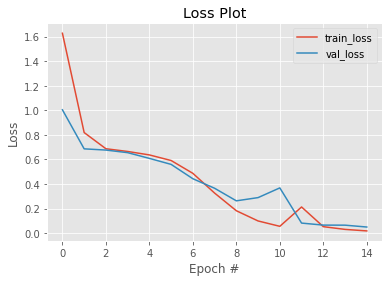

In [64]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 15), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 15), H.history["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

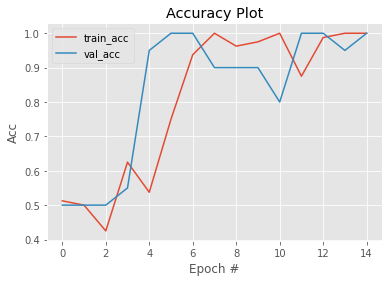

In [65]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 15), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, 15), H.history["val_acc"], label="val_acc")
plt.title("Accuracy Plot")
plt.xlabel("Epoch #")
plt.ylabel("Acc")
plt.legend()
plt.show()

In [66]:
from sklearn.metrics import classification_report

pred = model.predict(x_val)
labels = (pred > 0.5).astype(np.int)

print(classification_report(y_val, labels))

              precision    recall  f1-score   support

           0       0.56      0.18      0.27       500
           1       0.51      0.86      0.64       500

    accuracy                           0.52      1000
   macro avg       0.54      0.52      0.46      1000
weighted avg       0.54      0.52      0.46      1000

